In [1]:
from imports import *


In [2]:
query = "select * from train_data"
train_data = sql_connect(query)
X_train = train_data.drop(columns=['TARGET'])
y_train = train_data['TARGET']
del train_data
X_train.head()

Connection to SQL Server established successfully.
Connection closed.


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AVERAGE_EXTERNAL_RATING,TOT_PREV_APP,PREV_APPROVED_CNT,PREV_CANCELLED_CNT,PREV_REFUSED_CNT,PREV_UNUSED_CNT,ISMISSING_BUREAU_INFO
0,Cash loans,M,0,1,1,126000.0,545040.0,17244.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010966,-9470,-1114,-9301.0,-2142.0,-1,1,1,0,1,1,0,Drivers,3,2,2,TUESDAY,15,0,0,0,0,1,1,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.5739,0,0,0,0,0,0
1,Cash loans,F,0,1,0,135000.0,269550.0,18760.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.035792,-24367,365243,-13226.0,-4579.0,-1,1,0,0,1,1,0,Retired,2,2,2,WEDNESDAY,15,0,0,0,0,0,0,NA,0,0,0,0,-1052,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.7012,0,0,0,0,0,1
2,Cash loans,M,0,0,0,270000.0,497520.0,33246.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.008474,-10739,-353,-1418.0,-1843.0,-1,1,1,1,1,0,0,Laborers,2,2,2,SUNDAY,11,1,1,0,1,1,0,Business Entity Type 2,0,0,0,0,-251,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.3572,0,0,0,0,0,0
3,Revolving loans,F,0,1,0,112500.0,315000.0,15750.0,315000.0,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,0.035792,-21202,365243,-15132.0,-3152.0,-1,1,0,0,1,1,0,Retired,1,2,2,SATURDAY,11,0,0,0,0,0,0,NA,0,0,0,0,-551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,8.0,0.5516,0,0,0,0,0,0
4,Revolving loans,F,1,1,2,225000.0,450000.0,22500.0,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.028663,-12341,-4904,-6217.0,-4151.0,24,1,1,0,1,0,0,Accountants,4,2,2,WEDNESDAY,11,0,0,0,1,0,1,Business Entity Type 2,0,0,0,0,-292,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.4927,0,0,0,0,0,0


### Insights from Exploratory Data Analysis (EDA)

- **Class Imbalance**  
  The target variable exhibits class imbalance, which may negatively affect model performance.  

- **Skewed Feature Distributions**  
  Several features are highly skewed. Log transformation has been applied to reduce skewness and stabilize variance.

- **Varied Feature Scales**  
  Features are on different scales, which can affect distance-based models.  

- **High Dimensionality and Multicollinearity**  
  The dataset has a large number of features, increasing the risk of multicollinearity and overfitting.  

---

Proceeding to modeling...


### Preprocessing steps

In [3]:
from preprocessing_util import get_column_groups, get_transformers

column_groups = get_column_groups(X_train)


In [4]:
transformers = get_transformers(
    column_groups['log_col'],
    column_groups['scale_only_cols'],
    column_groups['categorical_cols']
)

### Modeling Plan

We will train and evaluate **4 different logistic regression-based models** to understand the impact of preprocessing and regularization techniques:

---

#### Model 1: Logistic Regression (Log-Transformed + Standardized Features)  
- Applies log transformation to reduce skewness and standardization to align feature scales.  
- Baseline model with no regularization or dimensionality reduction.  
- Risk: Still susceptible to multicollinearity due to high dimensionality.

---

#### Model 2: Lasso Logistic Regression (L1 Regularization)  
- Adds an L1 penalty, which can shrink some coefficients to exactly zero.  
- Performs automatic feature selection and encourages sparsity.  
- Requires feature standardization.

---

#### Model 3: Ridge Logistic Regression (L2 Regularization)  
- Adds an L2 penalty to shrink coefficients without eliminating any.  
- Useful when many predictors contribute small effects.  
- Requires feature standardization.

---

#### Model 4: Logistic Regression with PCA  
- Reduces the feature space using Principal Component Analysis.  
- Helps mitigate multicollinearity and overfitting.  
- Number of components is selected to retain 90% of variance.


### Evaluation and Cross-Validation Strategy

#### Evaluation Metrics

As identified during EDA, the dataset has a class imbalance, so accuracy is not a suitable metric. Instead, we prioritize metrics that are sensitive to minority class detection:

- **Recall** (Highest Priority):  
  Our primary goal is to correctly identify customers likely to face payment difficulties.  
  Why? Missing such customers (false negatives) can lead to financial loss.

- **Precision** (Secondary Priority):  
  Important to reduce false positives, but less critical than recall in this context.

- **F1 Score** (Balanced Metric):  
  Harmonic mean of precision and recall — used for overall performance comparison.

---

#### Cross-Validation Strategy

- We will use **Stratified K-Fold Cross-Validation** (e.g., `k=5`) on the training set to ensure that the **class distribution is preserved** in each fold.
- This provides more **reliable and fair model evaluation**, especially in the presence of class imbalance.
- Stratified K-Fold reduces variance compared to a single train/validation split and ensures that each fold is representative of the overall dataset.

**Cross-validation will be used for:**
- Hyperparameter tuning
- Model selection
- Estimating generalization performance

---

#### Threshold Selection

- Since we use probabilistic models (like logistic regression), we’ll explore different classification thresholds.
- Instead of the default 0.5, we’ll use the Precision-Recall (PR) curve to select an optimal threshold:
  - This helps balance recall and precision based on business needs.
  - The threshold can be selected at the maximum F1 score or based on a minimum acceptable recall.

---

This setup aligns our model evaluation with real-world business impact and ensures robustness through validation.


In [5]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score, roc_auc_score
  

In [6]:
preprocessor = ColumnTransformer(transformers=transformers)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
pipeline_1 = Pipeline(
    [('preprocess', preprocessor),
    ('clf', LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000, random_state=42, class_weight='balanced'))]
)

y_scores = {}

model_1_cv = cross_val_predict(
    pipeline_1,
    X_train, y_train,
    cv=cv_strategy,
    method='predict_proba',
    verbose=1
    )

y_scores['Model_1'] =  model_1_cv[:, 1]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.4s finished


In [8]:
pipeline_2 = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=10000))
])

param_grid = {
    'model__C': [0.01, 0.1, 1]
}

print("Starting Grid Search for Model 2...")
grid = GridSearchCV(pipeline_2, param_grid, cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
model_2_best_param = grid.best_params_['model__C']
print(f"Best parameter for Model 2: {model_2_best_param}")

print("Starting cross-validation for Model 2...")
y_scores['Model_2'] = cross_val_predict(
    grid.best_estimator_,
    X_train,
    y_train,
    cv=cv_strategy,
    method='predict_proba',
    n_jobs=-1,
    verbose=1
)[:, 1]

Starting Grid Search for Model 2...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameter for Model 2: 0.1
Starting cross-validation for Model 2...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


In [9]:
pipeline_3 = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', max_iter=10000))
])

param_grid = {
    'model__C': [0.0001, 0.01, 0.1, 1]
}

print("Starting Grid Search for Model 3...")
grid = GridSearchCV(pipeline_3, param_grid, cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
model_3_best_param = grid.best_params_['model__C']
print(f"Best parameter for Model 3: {model_3_best_param}")
#print(grid.best_estimator_)

print("Starting cross-validation for Model 3...")
y_scores['Model_3'] = cross_val_predict(
    grid.best_estimator_,
    X_train,
    y_train,
    cv=cv_strategy,
    method='predict_proba',
    n_jobs=-1,
    verbose=1
)[:, 1]

Starting Grid Search for Model 3...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter for Model 3: 0.01
Starting cross-validation for Model 3...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [10]:
preprocessor = ColumnTransformer(
    transformers=transformers,
    sparse_threshold=0.0  
)

pipeline_4 = Pipeline([
    ('preprocess', preprocessor),
    ('PCA', PCA(n_components=0.90, svd_solver='full', random_state=42)),
    ('clf', LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000, random_state=42, class_weight='balanced'))
])

print("Starting cross-validation for Model 4...")
model_4_cv = cross_val_predict(
    pipeline_4,
    X_train, y_train,
    cv=cv_strategy,
    method='predict_proba',
    verbose=1
    )

y_scores['Model_4'] =  model_4_cv[:, 1]

Starting cross-validation for Model 4...


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


In [11]:
pipeline_4.fit(X_train, y_train)

fitted_pca = pipeline_4.named_steps['PCA']

print("Number of PCA components selected:", fitted_pca.n_components_)


Number of PCA components selected: 29


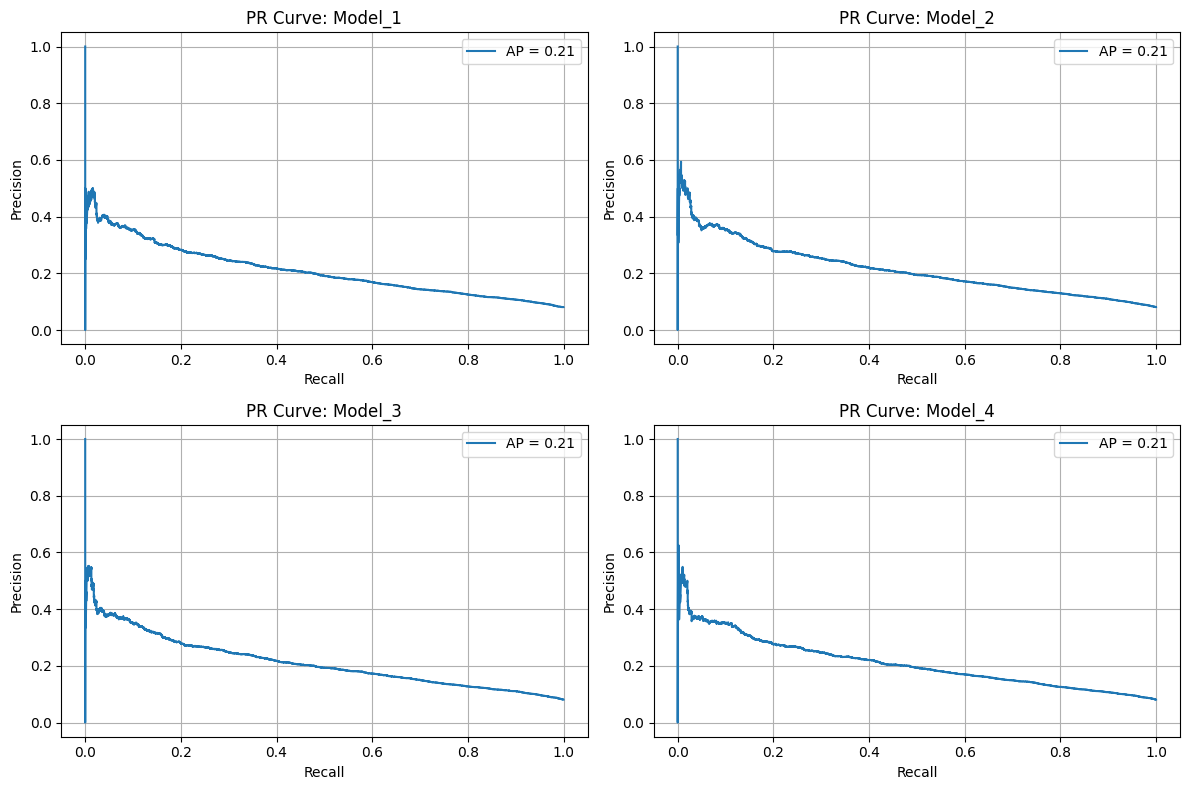

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))  # 4 models → 2x2 grid
axes = axes.flatten()

for i, (model_name, y_prob) in enumerate(y_scores.items()):
    precision, recall, _ = precision_recall_curve(y_train, y_prob)
    ap = average_precision_score(y_train, y_prob)

    ax = axes[i]
    ax.plot(recall, precision, label=f'AP = {ap:.2f}')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"PR Curve: {model_name}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


### Summary of Logistic Regression Models

All four logistic regression–based models — including baseline logistic regression, L1 (Lasso), L2 (Ridge), and PCA-based logistic regression — demonstrated **similar and relatively poor performance**, with an average precision (AP) of only **0.21** across the board, which it is not able to differentiate postiive classes effectively.

Despite applying log transformation, feature standardization, regularization, and dimensionality reduction, **none of the models achieved meaningful separation between the classes**. 

This strongly suggests that the underlying data is **not linearly separable**, limiting the effectiveness of linear classifiers such as logistic regression or that the available features are not sufficiently informative for linear classifiers. Therefore, we will now proceed to explore **more powerful, non-linear models** such as **Support Vector Machines (SVMs)** and **Random Forests**, which can better capture complex decision boundaries.
